In [322]:
'''
ROI collection and QC

Collect ROIs based on plane-specific optimal session-to-session registration methods
From the last slide of “220303 session-to-session registration”.
Extract signals from each ROIs from the “master ROI map”.
For each ROI map, log if the ROI was present at each session.
For QC
Log each session's depth span.
For flexible depth difference threshold.
QC
(1) Compare between the signal from the master ROI and the one from that session. 
To check if using unified master ROI is OK.
(2) Compare between the signal from the master ROI that was NOT in the session and other ROIs present in that session.
To check if assigning an ROI to sessions without that ROI is OK. But how?
SNR distribution compared to the session-curated neurons.
Signal comparison between adjacent sessions (without learning).

======
Copy registration from 220302_another_registration_test.py
Copy ROI collection from 220117_roi_collection.py
Use z-drift data from 220117_roi_collection.py
Save the registration parameters and results as JK{mouse:03}plane{pn}_session_to_session_registration.npy
Save the master map as JK{mouse:03}plane{n}_roi_collection.npy

======

2022/06/05 JK
'''

#%% BS
import pandas
import numpy as np
import matplotlib.pyplot as plt
import napari
import os, glob, shutil
from pystackreg import StackReg
from skimage import exposure
from suite2p.registration import rigid, nonrigid
from tqdm.notebook import tqdm
from functools import reduce

import gc
gc.enable()

h5Dir = 'D:/TPM/JK/h5/'
# h5Dir = 'D:/'

# mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
# freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    6.1,    6.1,    6.1,    7.7,    7.7,    7.7,    7.7]

mice =          [25,    27,   30,   36,     39,     52]
refSessions =   [4,     3,    3,    1,      1,      3]
expSessions =   [19,    10,   21,   17,     23,     21]
zoom =          [2,     2,    2,    1.7,    1.7,    1.7]
freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    7.7]

optimal_reg_methods = {'025': ['bilinear', 'bilinear', 'suite2p', 'bilinear', 'old', 'old', 'old', 'old'],
                        '027': ['bilinear', 'bilinear', 'bilinear', 'bilinear', 'suite2p', 'suite2p', 'affine', 'bilinear'],
                        '030': ['old', 'old', 'old', 'bilinear', 'affine', 'bilinear', 'bilinear', 'bilinear'],
                        '036': ['old', 'old', 'old', 'suite2p', 'suite2p', 'bilinear', 'old', 'bilinear'],
                        '039': ['suite2p', 'suite2p', 'suite2p', 'suite2p', 'affine', 'affine', 'affine', 'affine'],
                        '052': ['bilinear', 'bilinear', 'bilinear', 'bilinear', 'bilinear', 'bilinear', 'bilinear', 'affine']}
relative_depths_selected = {'025': [[7,17], [18,28]],
                            '027': [[20,30], [25,35]],
                            '030': [[17,27], [22,32]],
                            '036': [[16,26], [12,22]],
                            '039': [[22,32], [17,27]],
                            '052': [[27,37], [17,27]]} # per imaged volume
manual_removal_Session_i = {'025': [[7,14], []],
                            '027': [range(7,12), []],
                            '030': [[], [19]],
                            '036': [[17], [19]],
                            '039': [[], []],
                            '052': [[], []]} # per imaged volume
prevN = 3
op = {'smooth_sigma': 1.15, 'maxregshift': 0.3, 'smooth_sigma_time': 0, 'snr_thresh': 1.2, 'block_size_list': [128,32]}
roi_overlap_threshold = 0.5
# When two ROIs have an overlap, if this overlap/area is larger than the threshold
# for EITHER of the ROIs, then these two ROIs are defined as matching
# This is the same approach as in suite2p, and stricter than that of CaImAn (where intersection/union is used instead)

#%% Helper functions

# Functions for registration
def clahe_each(img: np.float64, kernel_size = None, clip_limit = 0.01, nbins = 2**16):
    newimg = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    newimg = exposure.equalize_adapthist(newimg, kernel_size = kernel_size, clip_limit = clip_limit, nbins=nbins)    
    return newimg

def twostep_register(img, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                     rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2):
    frames = img.copy().astype(np.float32)
    if len(frames.shape) == 2:
        frames = np.expand_dims(frames, axis=0)
    elif len(frames.shape) < 2:
        raise('Dimension of the frames should be at least 2')
    elif len(frames.shape) > 3:
        raise('Dimension of the frames should be at most 3')
    (Ly, Lx) = frames.shape[1:]
    # 1st rigid shift
    frames = np.roll(frames, (-rigid_y1, -rigid_x1), axis=(1,2))
    # 1st nonrigid shift
    yblock, xblock, nblocks, block_size, NRsm = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=block_size1)
    ymax1 = np.tile(nonrigid_y1, (frames.shape[0],1))
    xmax1 = np.tile(nonrigid_x1, (frames.shape[0],1))
    frames = nonrigid.transform_data(data=frames, nblocks=nblocks, 
        xblock=xblock, yblock=yblock, ymax1=ymax1, xmax1=xmax1)
    # 2nd rigid shift
    frames = np.roll(frames, (-rigid_y2, -rigid_x2), axis=(1,2))
    # 2nd nonrigid shift            
    yblock, xblock, nblocks, block_size, NRsm = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=block_size2)
    ymax1 = np.tile(nonrigid_y2, (frames.shape[0],1))
    xmax1 = np.tile(nonrigid_x2, (frames.shape[0],1))
    frames = nonrigid.transform_data(data=frames, nblocks=nblocks, 
        xblock=xblock, yblock=yblock, ymax1=ymax1, xmax1=xmax1)
    return frames

def s2p_2step_nr(mimgList, refMimg, op):
    op['block_size'] = [op['block_size_list'][0], op['block_size_list'][0]]
    mimgList1step, roff1, nroff1 = s2p_nonrigid_registration(mimgList, refMimg, op)
    op['block_size'] = [op['block_size_list'][1], op['block_size_list'][1]]
    mimgList2step, roff2, nroff2 = s2p_nonrigid_registration(mimgList1step, refMimg, op)
    return mimgList2step, roff1, roff2, nroff1, nroff2

def s2p_nonrigid_registration(mimgList, refImg, op):
    ### ------------- compute registration masks ----------------- ###
    Ly, Lx = refImg.shape
    maskMul, maskOffset = rigid.compute_masks(
        refImg=refImg,
        maskSlope= 3 * op['smooth_sigma'],
    )
    cfRefImg = rigid.phasecorr_reference(
        refImg=refImg,
        smooth_sigma=op['smooth_sigma'],
        # pad_fft=ops['pad_fft'], # False by default
    )

    yblock, xblock, nblocks, block_size, NRsm = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=op['block_size'])
    
    maskMulNR, maskOffsetNR, cfRefImgNR = nonrigid.phasecorr_reference(
        refImg0=refImg,
        maskSlope=3 * op['smooth_sigma'], # slope of taper mask at the edges
        smooth_sigma=op['smooth_sigma'],
        yblock=yblock,
        xblock=xblock,
        # pad_fft=ops['pad_fft'], # False by default
    )

    ### ------------- register binary to reference image ------------ ###
    
    # mean_img = np.zeros((Ly, Lx))
    rigid_offsets, nonrigid_offsets = [], []
    frames = np.array(mimgList).astype(np.float32)
    fsmooth = frames.copy().astype(np.float32)

    # rigid registration
    ymax, xmax, cmax = rigid.phasecorr(
        data=rigid.apply_masks(data=fsmooth, maskMul=maskMul, maskOffset=maskOffset),
        cfRefImg=cfRefImg,
        maxregshift=op['maxregshift'],
        smooth_sigma_time=op['smooth_sigma_time'],
    )
    rigid_offsets.append([ymax, xmax, cmax])

    for frame, dy, dx in zip(frames, ymax, xmax):
        frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)

    # non-rigid registration
    # need to also shift smoothed data (if smoothing used)
    fsmooth = frames.copy()
        
    ymax1, xmax1, cmax1 = nonrigid.phasecorr(
        data=fsmooth,
        maskMul=maskMulNR.squeeze(),
        maskOffset=maskOffsetNR.squeeze(),
        cfRefImg=cfRefImgNR.squeeze(),
        snr_thresh=op['snr_thresh'],
        NRsm=NRsm,
        xblock=xblock,
        yblock=yblock,
        maxregshiftNR=op['block_size'][0]//10,
    )

    frames2 = nonrigid.transform_data(
        data=frames,
        nblocks=nblocks,
        xblock=xblock,
        yblock=yblock,
        ymax1=ymax1,
        xmax1=xmax1,
    )

    nonrigid_offsets.append([ymax1, xmax1, cmax1])
    
    return frames2, rigid_offsets, nonrigid_offsets

def fix_reg_collection(reg_result):
    '''
    Fixing registration result collection of the 'new' suite2p method.
    2022/07/13 JK
    '''
    num_sessions = len(reg_result['selected_session_num'])
    roff1_y = [0]
    roff1_x = [0]
    roff1_c = [0.1]
    roff1 = reg_result['suite2p_result']['roff1']
    for i in range(num_sessions-1):
        roff1_y.append([x[0] for x in roff1[i]][0])
        roff1_x.append([x[0] for x in roff1[i]][1])
        roff1_c.append([x[0] for x in roff1[i]][2])
    roff1 = [[np.array(roff1_y), np.array(roff1_x), np.array(roff1_c)]]
    reg_result['suite2p_result']['roff1'] = roff1

    roff2_y = [0]
    roff2_x = [0]
    roff2_c = [0.1]
    roff2 = reg_result['suite2p_result']['roff2']
    for i in range(num_sessions-1):
        roff2_y.append([x[0] for x in roff2[i]][0])
        roff2_x.append([x[0] for x in roff2[i]][1])
        roff2_c.append([x[0] for x in roff2[i]][2])
    roff2 = [[np.array(roff2_y), np.array(roff2_x), np.array(roff2_c)]]
    reg_result['suite2p_result']['roff2'] = roff2

    offset_len = len(reg_result['suite2p_result']['nroff1'][0][0][0])
    nroff1_y = [np.zeros(offset_len)]
    nroff1_x = [np.zeros(offset_len)]
    nroff1_c = [np.ones(offset_len)/10]
    nroff1 = reg_result['suite2p_result']['nroff1']
    for i in range(num_sessions-1):
        nroff1_y.append([x[0] for x in nroff1[i]][0])
        nroff1_x.append([x[0] for x in nroff1[i]][1])
        nroff1_c.append([x[0] for x in nroff1[i]][2])
    nroff1 = [[np.array(nroff1_y).astype(np.float32), np.array(nroff1_x).astype(np.float32), np.array(nroff1_c).astype(np.float32)]]
    reg_result['suite2p_result']['nroff1'] = nroff1
    
    offset_len = len(reg_result['suite2p_result']['nroff2'][0][0][0])
    nroff2_y = [np.zeros(offset_len)]
    nroff2_x = [np.zeros(offset_len)]
    nroff2_c = [np.ones(offset_len)/10]
    nroff2 = reg_result['suite2p_result']['nroff2']
    for i in range(num_sessions-1):
        nroff2_y.append([x[0] for x in nroff2[i]][0])
        nroff2_x.append([x[0] for x in nroff2[i]][1])
        nroff2_c.append([x[0] for x in nroff2[i]][2])
    nroff2 = [[np.array(nroff2_y).astype(np.float32), np.array(nroff2_x).astype(np.float32), np.array(nroff2_c).astype(np.float32)]]
    reg_result['suite2p_result']['nroff2'] = nroff2

    return reg_result

# Functions for ROI collection
def calculate_regCell_threshold(cellMap, numPix, thresholdResolution = 0.01):
    trPrecision = len(str(thresholdResolution).split('.')[1])
    thresholdRange = np.around(np.arange(0.3,1+thresholdResolution/10,thresholdResolution), trPrecision)
    threshold = thresholdRange[np.argmin([np.abs(numPix - np.sum(cellMap>=threshold)) for threshold in thresholdRange])]
    cutMap = (cellMap >= threshold).astype(bool)
    return cutMap, threshold

def perimeter_area_ratio(img: bool):
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=0)
    if len(img.shape) != 3:
        raise('Input image dimension should be either 2 or 3.')
    img = img.astype('bool')
    numCell = img.shape[0]
    par = np.zeros(numCell)
    for ci in range(numCell):
        tempImg = img[ci,:,:]
        inside = tempImg*np.roll(tempImg,1,axis=0)*np.roll(tempImg,-1,axis=0)*np.roll(tempImg,1,axis=1)*np.roll(tempImg,-1,axis=1)
        perimeter = np.logical_xor(tempImg, inside)
        par[ci] = np.sum(perimeter)/np.sum(tempImg) # tempImg instead of inside just to prevent dividing by 0 for some scattered rois
    return par

def check_multi_match_pair(multiMatchMasterInd, multiMatchNewInd, masterPar, newPar, 
                           overlapMatrix, overlaps, unions, delFromMasterInd, delFromNewInd):
    tempDfMasterInd = np.zeros(0,'int')
    tempDfNewInd = np.zeros(0,'int')
    remFromMMmaster = np.zeros(0,'int') # Collect multiMatchMasterInd that is already processed (in the for loop)
    remFromMMnew = np.zeros(0,'int') # Collect multiMatchNewInd that is already processed (in the for loop)
    # Remove remFromMM* at the end.
    
    # First, deal with delFromMasterInd
    if len(multiMatchMasterInd)>0:
        for mci in range(len(multiMatchMasterInd)):
            masterCi = multiMatchMasterInd[mci]
            if masterCi in remFromMMmaster: # For the updates from the loop.
                continue
            else:
                # cell index from the new map, that matches with this master ROI.
                newCis = np.where(overlapMatrix[masterCi,:])[0] # This should be longer than len == 1, by definition of multiMatchMasterInd.
                
                # Calculate any other master ROIs that overlap with this new ROI(s).
                masterBestMatchi = np.zeros(len(newCis), 'int')
                for i, nci in enumerate(newCis):
                    masterBestMatchi[i] = np.argmax(overlaps[:,nci]).astype(int)
                # Check if the best-matched master ROIs for these multiple new ROIs are this master ROI.
                # (I.e., when a large combined master ROI covers more than one new ROIs. 
                # See 220117 ROI collection across sessions with matching depth.pptx)
                # In this case, just remove this master ROI
                if any([len(np.where(masterBestMatchi==mi)[0])>1 for mi in masterBestMatchi]):
                    tempDfMasterInd = np.hstack((tempDfMasterInd, [masterCi]))
                    remFromMMmaster = np.hstack((remFromMMmaster, [masterCi]))
                
                # Else, check if there is a matching pair (or multiples)
                # I.e., multiple overlapping new ROIs with multiple master ROIs (usually couples in both ROI maps)
                # In this case, remove the pair (or multiples) with higher mean PAR 
                else:
                    newBestMatchi = np.zeros(len(masterBestMatchi), 'int')
                    for i, mci in enumerate(masterBestMatchi):
                        newBestMatchi[i] = np.argmax(overlaps[mci,:]).astype(int)

                    if all(newCis == newBestMatchi): # found a matching pair (or a multiple)
                        # Calculate mean perimeter/area ratio
                        masterMeanpar = np.mean(masterPar[masterBestMatchi])
                        newMeanpar = np.mean(newPar[newBestMatchi])
                        
                        # Remove the pair with higher mean par
                        if masterMeanpar <= newMeanpar:
                            tempDfNewInd = np.hstack((tempDfNewInd, newBestMatchi))
                        else:
                            tempDfMasterInd = np.hstack((tempDfMasterInd, masterBestMatchi))
    
                        # Collect indices already processed
                        remFromMMmaster = np.hstack((remFromMMmaster, masterBestMatchi))
                        remFromMMnew = np.hstack((remFromMMnew, newBestMatchi))
                              
    # Then, deal with delFromNewInd
    if len(multiMatchNewInd)>0:
        for nci in range(len(multiMatchNewInd)):
            newCi = multiMatchNewInd[nci]
            if newCi in remFromMMnew:
                continue
            else:
                masterCis = np.where(overlapMatrix[:,newCi])[0]
                    
                newBestMatchi = np.zeros(len(masterCis), 'int')
                for i, mci in enumerate(masterCis):
                    newBestMatchi[i] = np.argmax(overlaps[mci,:]).astype(int)
                    
                # Check if there are multiple same matched IDs 
                # In this case, just remove the new ROI
                if any([len(np.where(newBestMatchi==ni)[0])>1 for ni in newBestMatchi]):
                    tempDfNewInd = np.hstack((tempDfNewInd, [newCi]))
                    remFromMMnew = np.hstack((remFromMMnew, [newCi]))
                
                # Else, check if there is a matching pair (or multiples)
                else:
                    masterBestMatchi = np.zeros(len(newBestMatchi), 'int')
                    for i, nci in enumerate(newBestMatchi):
                        masterBestMatchi[i] = np.argmax(overlaps[:,nci]).astype(int)

                    if all(masterCis == masterBestMatchi): # found a matching pair
                        # Calculate mean perimeter/area ratio
                        masterMeanpar = np.mean(masterPar[masterBestMatchi])
                        newMeanpar = np.mean(newPar[newBestMatchi])
                        
                        # Remove the pair with higher mean par
                        if masterMeanpar <= newMeanpar:
                            tempDfNewInd = np.hstack((tempDfNewInd, newBestMatchi))
                        else:
                            tempDfMasterInd = np.hstack((tempDfMasterInd, masterBestMatchi))
    
                        # Collect indices already processed
                        remFromMMmaster = np.hstack((remFromMMmaster, masterBestMatchi))
                        remFromMMnew = np.hstack((remFromMMnew, newBestMatchi))
    
    # Remove collected indices
    if len(tempDfMasterInd)>0:
        delFromMasterInd.extend(tempDfMasterInd)
    if len(tempDfNewInd)>0:
        delFromNewInd.extend(tempDfNewInd)
    
    # Ideally, these multi indices should be empty.    
    multiMatchMasterInd = np.array([mi for mi in multiMatchMasterInd if mi not in remFromMMmaster])
    multiMatchNewInd = np.array([ni for ni in multiMatchNewInd if ni not in remFromMMnew])

    # If there are still multi matches left, match them using intesection/union
    intersect_over_union = overlaps/unions
    if len(multiMatchMasterInd) > 0:
        for mci in range(len(multiMatchMasterInd)):
            masterCi = multiMatchMasterInd[mci]
            if masterCi in remFromMMmaster: # For the updates from the loop.
                continue
            else:
                # cell index from the new map, that matches with this master ROI.
                newCis = np.where(overlapMatrix[masterCi,:])[0] # This should be longer than len == 1, by definition of multiMatchMasterInd.
                newBestMatchi = newCis[np.argmax(intersect_over_union[masterCi,newCis])]
                # Remove the cell with higher mean par
                if masterPar[masterCi] <= newPar[newBestMatchi]:
                    tempDfNewInd = np.hstack((tempDfNewInd, newBestMatchi))
                    remFromMMnew = np.hstack((remFromMMnew, newBestMatchi))
                else:
                    tempDfMasterInd = np.hstack((tempDfMasterInd, masterCi))
                remFromMMmaster = np.hstack((remFromMMmaster, masterCi))
    if len(multiMatchNewInd) > 0:
        for nci in range(len(multiMatchNewInd)):
            newCi = multiMatchNewInd[nci]
            if newCi in remFromMMnew: # For the updates from the loop.
                continue
            else:
                # cell index from the new map, that matches with this master ROI.
                masterCis = np.where(overlapMatrix[:,newCi])[0] # This should be longer than len == 1, by definition of multiMatchMasterInd.
                masterBestMatchi = masterCis[np.argmax(intersect_over_union[masterCis,newCi])]
                # Remove the cell with higher mean par
                if newPar[newCi] <= masterPar[masterBestMatchi]:
                    tempDfMasterInd = np.hstack((tempDfMasterInd, masterBestMatchi))
                    remFromMMmaster = np.hstack((remFromMMmaster, masterBestMatchi))
                else:
                    tempDfNewInd = np.hstack((tempDfNewInd, newCi))
                remFromMMnew = np.hstack((remFromMMnew, newCi))
    
    # Remove collected indices
    if len(tempDfMasterInd)>0:
        delFromMasterInd.extend(tempDfMasterInd)
    if len(tempDfNewInd)>0:
        delFromNewInd.extend(tempDfNewInd)
        
    # Ideally, these multi indices should be empty.    
    multiMatchMasterInd = np.array([mi for mi in multiMatchMasterInd if mi not in remFromMMmaster])
    multiMatchNewInd = np.array([ni for ni in multiMatchNewInd if ni not in remFromMMnew])


    return delFromMasterInd, delFromNewInd, multiMatchMasterInd, multiMatchNewInd



def imblend_for_napari(refImg, testImg):
    if (len(refImg.shape) != 2) or (len(testImg.shape) != 2):
        raise('Both images should have 2 dims.')
    if any(np.array(refImg.shape)-np.array(testImg.shape)):
        raise('Both images should have matching dims')
    refImg = img_norm(refImg.copy())
    testImg = img_norm(testImg.copy())
    refRGB = np.moveaxis(np.tile(refImg,(3,1,1)), 0, -1)
    testRGB = np.moveaxis(np.tile(testImg,(3,1,1)), 0, -1)
    blended = imblend(refImg, testImg)
    return np.array([refRGB, testRGB, blended])

def img_norm(img):
    return (img - np.amin(img)) / (np.amax(img) - np.amin(img))

def imblend(refImg, testImg):
    if (len(refImg.shape) != 2) or (len(testImg.shape) != 2):
        raise('Both images should have 2 dims.')
    if any(np.array(refImg.shape)-np.array(testImg.shape)):
        raise('Both images should have matching dims')
    Ly,Lx = refImg.shape
    blended = np.zeros((Ly,Lx,3))
    blended[:,:,0] = refImg
    blended[:,:,2] = testImg
    blended[:,:,1] = refImg
    return blended

# Run registration.
# Ran all the mice and planes, and saved them.
2022/06/24

In [ ]:
# for mi in range(6):
#     for pn in range(1,9):

#         mouse=mice[mi]
#         mouse_str = f'{mouse:03}'
#         reg_meth = optimal_reg_methods[mouse_str][pn-1]
#         refSn = refSessions[mi] # for 'old' method

#         if pn < 5:
#             vi = 0 # volume index, either 1 or 5
#             vn = 1
#         else:
#             vi = 1
#             vn = 5

#         selDepthsRV = relative_depths_selected[mouse_str][vi]
#         manRmvSi = manual_removal_Session_i[mouse_str][vi]

#         # Load z-drift data
#         zdrift = np.load(f"{h5Dir}JK{mouse:03}_zdrift_plane{vn}.npy", allow_pickle=True).item()

#         # Select training sessions only
#         # Re-order sessions if necessary
#         siArr = np.where([len(sn.split('_'))==2 for sn in zdrift['info']['sessionNames']])[0]
#         snums = np.array([int(sn.split('_')[1]) for sn in zdrift['info']['sessionNames'] if len(sn.split('_'))==2])
#         siSorted = siArr[np.argsort(snums)]

#         # Select sessions
#         selectedSi = np.array([si for si in siSorted if \
#                     sum(np.logical_and(zdrift['zdriftList'][si]>=selDepthsRV[0], zdrift['zdriftList'][si]<=selDepthsRV[1])) >=3 ])
#         selectedSnums = [int(sname.split('_')[1]) for sname in np.array(zdrift['info']['sessionNames'])[selectedSi]]

#         if len(manRmvSi)>0:
#             selectedSi = np.delete(selectedSi, manRmvSi)
#             selectedSnums = np.delete(selectedSnums, manRmvSi)

#         zdrift_list = [zdrift['zdriftList'][si] for si in selectedSi]

#         # To deal with the rolling effect of suite2p within-session registration
#         leftBuffer = 30
#         rightBuffer = 30 if mouse < 50 else 100
#         bottomBuffer = 10
#         topBuffer = 50

#         edge_buffer = {'leftBuffer': leftBuffer,
#                     'rightBuffer': rightBuffer,
#                     'bottomBuffer': bottomBuffer,
#                     'topBuffer': topBuffer}

#         planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
#         # regFn = f'{planeDir}s2p_nr_reg_bu1.npy' # for JK052. Need to get rid of _bu1.py file
#         # Ignore this for now. If the result looks weird 

#         numSelected = len(selectedSi)
#         mimgs = []
#         mimgClahe = []
#         refOld = []
#         for si, sn in enumerate(selectedSnums):
#             opsFn = f'{planeDir}{sn:03}/plane0/ops.npy'
#             ops = np.load(opsFn, allow_pickle=True).item()
#             mimg = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
#             mimgs.append(mimg)
#             mimgClahe.append(clahe_each(mimg))
#             if sn == refSn:
#                 refOld = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
#         if len(refOld) == 0:
#             raise('Reference session image not defined (for old reg method).')
#         # Change axes of mimgs and mimgClahe to match with previous coding (suite2p legacy)
#         mimgs = np.moveaxis(np.dstack(mimgs), -1, 0)
#         mimgClahe = np.moveaxis(np.dstack(mimgClahe), -1, 0)

#         srBi = StackReg(StackReg.BILINEAR)
#         srAffine = StackReg(StackReg.AFFINE)
#         regBi = np.zeros_like(mimgs)
#         regAffine = np.zeros_like(mimgs)
#         regS2p = np.zeros_like(mimgs)
#         regOld = np.zeros_like(mimgs)

#         tformsBi = []
#         tformsAffine = []

#         roff1 = []
#         roff2 = []
#         nroff1 = []
#         nroff2 = []

#         roff1Old = []
#         roff2Old = []
#         nroff1Old = []
#         nroff2Old = []

#         if reg_meth == 'old':
#             regOld, roff1Old, roff2Old, nroff1Old, nroff2Old= s2p_2step_nr(mimgs, refOld, op)
#         else:
#             for si in range(numSelected):
#                 if si == 0:
#                     if reg_meth == 'bilinear':
#                         regBi[si,:,:] = mimgs[si,:,:]
#                         tformsBi.append(np.eye(4))
#                     elif reg_meth == 'affine':
#                         regAffine[si,:,:] = mimgs[si,:,:]
#                         tformsAffine.append(np.eye(3))
#                     elif reg_meth == 'suite2p':
#                         regS2p[si,:,:] = mimgs[si,:,:]
#                         _, roff1tmp, roff2tmp, nroff1tmp, nroff2tmp = s2p_2step_nr([mimgs[si,:,:]], mimgs[si,:,:], op)
#                           ### Did not add this first transformation. Need to take care when applying the transformation. (During ROI collection)
#                     else:
#                         raise('Registration method error.')

#                 else:
#                     previStart = max(0,si-prevN)
#                     if reg_meth == 'bilinear':
#                         refBi = clahe_each(np.mean(regBi[previStart:si,:,:], axis=0))
#                         tform = srBi.register(refBi, mimgClahe[si,:,:])
#                         regBi[si,:,:] = srBi.transform(mimgs[si,:,:], tmat=tform)
#                         tformsBi.append(tform)
#                     elif reg_meth == 'affine':
#                         refAffine = clahe_each(np.mean(regAffine[previStart:si,:,:], axis=0))
#                         tform = srAffine.register(refAffine, mimgClahe[si,:,:])
#                         regAffine[si,:,:] = srAffine.transform(mimgs[si,:,:], tmat=tform)
#                         tformsAffine.append(tform)
#                     elif reg_meth == 'suite2p':
#                         refImg = np.mean(regS2p[previStart:si,:,:], axis=0)
#                         regS2p[si,:,:], roff1tmp, roff2tmp, nroff1tmp, nroff2tmp = s2p_2step_nr([mimgs[si,:,:]], refImg, op)
#                           ### This offset collection does not match with suite2p nonrigid registration method. Need to fix before ROI collection
#                         roff1.append(roff1tmp[0])
#                         roff2.append(roff2tmp[0])
#                         nroff1.append(nroff1tmp[0])
#                         nroff2.append(nroff2tmp[0])
#                     else:
#                         raise('Registration method error.')
#         bilinear_result = {'reg_image': regBi,
#                         'tforms': tformsBi,
#                         }
#         affine_result = {'reg_image': regAffine,
#                         'tforms': tformsAffine,
#                         }
#         suite2p_result = {'reg_image': regS2p,
#                         'roff1': roff1,
#                         'roff2': roff2,
#                         'nroff1': nroff1,
#                         'nroff2': nroff2,
#                         'block_size1': [op['block_size_list'][0], op['block_size_list'][0]],
#                         'block_size2': [op['block_size_list'][1], op['block_size_list'][1]],
#                         }
#         old_result = {'reg_image': regOld,
#                         'roff1': roff1Old,
#                         'roff2': roff2Old,
#                         'nroff1': nroff1Old,
#                         'nroff2': nroff2Old,
#                         'block_size1': [op['block_size_list'][0], op['block_size_list'][0]],
#                         'block_size2': [op['block_size_list'][1], op['block_size_list'][1]],
#                         }
#         result = {'mouse': mouse,
#                 'plane': pn,
#                 'edge_buffer': edge_buffer,
#                 'selected_session_i': selectedSi,
#                 'selected_session_num': selectedSnums,
#                 'zdrift_list': zdrift_list,
#                 'registration_method': reg_meth,
#                 'bilinear_result': bilinear_result, 
#                 'affine_result': affine_result,
#                 'suite2p_result': suite2p_result,
#                 'old_result': old_result
#                 }

#         save_fn = f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registartion.npy'

#         np.save(save_fn, result)



# Visually checking the registration

In [341]:
# Visually check the registration
mi = 0
pn = 5

mouse = mice[mi]
planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
load_fn = f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registartion.npy'
result = np.load(load_fn, allow_pickle=True).item()
reg_meth = result['registration_method']
if reg_meth == 'old':
    reg_img = result['old_result']['reg_image']
elif reg_meth == 'affine':
    reg_img = result['affine_result']['reg_image']
elif reg_meth == 'bilinear':
    reg_img = result['bilinear_result']['reg_image']
elif reg_meth == 'suite2p':
    reg_img = result['suite2p_result']['reg_image']
else:
    raise('Registration method mismatch.')
    
napari.view_image(reg_img)



divide by zero encountered in true_divide


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 163.0, 313.0), zoom=2.1822683706070287, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(0.0, 0.0, 0.0), scaled=True, size=1, style='standard'), dims=Dims(ndim=3, ndisplay=2, last_used=2, range=((0.0, 20.0, 1.0), (0.0, 326.0, 1.0), (0.0, 626.0, 1.0)), current_step=(0, 0, 0), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(enabled=False, stride=1, shape=(-1, -1)), layers=[<Image layer 'reg_img' at 0x27329bd4bb0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position='bottom_right', font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([1., 1., 1., 1.]), font_size=10.0, position='top_left', text=''), help='', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_wheel_callbacks=[<function dims_sc

# ROI collection
Run plane by plane, confirm it worked visually after each part.

In [392]:
# ROI collection test
mi = 2
pn = 5
mouse=mice[mi]

planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
registration_fn = f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registartion.npy'
reg_result = np.load(registration_fn, allow_pickle=True).item()
num_sessions = len(reg_result['selected_session_num'])
reg_meth = reg_result['registration_method']
# Fix the error with suite2p method offsets (was collecting in a wrong way)
# Match them with the 'old' method (2022/07/13 JK)
if reg_meth == 'suite2p':
    reg_result = fix_reg_collection(reg_result)

# Retrieve buffers, options, and dimensions
if reg_meth == 'old':
    reg_result_ops = reg_result['old_result']
    ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
    xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
elif reg_meth == 'suite2p':
    reg_result_ops = reg_result['suite2p_result']
    ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
    xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
elif reg_meth == 'affine':
    reg_result_ops = reg_result['affine_result']
elif reg_meth == 'bilinear':
    reg_result_ops = reg_result['bilinear_result']
else:
    raise('Registration method mismatch.')
reg_img = reg_result_ops['reg_image']
Ly, Lx = reg_img.shape[1:]

# Session-to-session registration creates non-overlaping regions at the edges.
# Set registration boundary to remove ROIs from each session that overlaps with the boundary.
if reg_meth == 'old' or reg_meth == 'suite2p':
    top_edge = max(reg_result_ops['roff1'][0][0])+5 # Adding 5 for nonrigid and 2nd step registrations.
    bottom_edge = min(reg_result_ops['roff1'][0][0])-5
    left_edge = max(reg_result_ops['roff1'][0][1])+5
    right_edge = min(reg_result_ops['roff1'][0][1])-5
    registration_boundary = np.ones(reg_img.shape[1:], 'uint8')
    registration_boundary[top_edge:bottom_edge, left_edge:right_edge] = 0
else:
    registration_boundary = np.sum(reg_img > 0,axis=0) < reg_img.shape[0]

# Go through sessions and collect ROIs into the master ROI map
# Pre-sessions (901 and 902) should be at the beginning

masterMap = np.zeros(0, 'bool')

srBi = StackReg(StackReg.BILINEAR)
srAffine = StackReg(StackReg.AFFINE)

leftBuffer = reg_result['edge_buffer']['leftBuffer']
topBuffer = reg_result['edge_buffer']['topBuffer']
rightBuffer = reg_result['edge_buffer']['rightBuffer']
bottomBuffer = reg_result['edge_buffer']['bottomBuffer']

master_map_list = []
new_master_map_list = []
session_map_list = []
new_map_list = []
viable_cell_index_list = []

# for test
session_og_map_list = []
session_after_buffer_map_list = []
session_reg_map_list = []
session_cut_map_list = []

print(f'ROI collection: JK{mouse:03} plane {pn}')
for si in tqdm(range(num_sessions)):
    snum = reg_result['selected_session_num'][si]
    sname = f'{mouse:03}_{snum:03}'
    print(f'Processing {sname} {si}/{num_sessions-1}')
    
    if (reg_meth == 'old') or (reg_meth == 'suite2p'):
        rigid_y1 = reg_result_ops['roff1'][0][0][si]
        rigid_x1 = reg_result_ops['roff1'][0][1][si]
        nonrigid_y1 = reg_result_ops['nroff1'][0][0][si]
        nonrigid_x1 = reg_result_ops['nroff1'][0][1][si]
        
        rigid_y2 = reg_result_ops['roff2'][0][0][si]
        rigid_x2 = reg_result_ops['roff2'][0][1][si]
        nonrigid_y2 = reg_result_ops['nroff2'][0][0][si]
        nonrigid_x2 = reg_result_ops['nroff2'][0][1][si]

        block_size1 = reg_result_ops['block_size1']
        block_size2 = reg_result_ops['block_size2']
    
    # Gather cell map and log session cell index for QC
    tempStat = np.load(f'{planeDir}{snum:03}/plane0/stat.npy', allow_pickle=True)
    tempIscell = np.load(f'{planeDir}{snum:03}/plane0/iscell.npy', allow_pickle=True)
    ops = np.load(f'{planeDir}{snum:03}/plane0/ops.npy', allow_pickle=True).item()
    Ly, Lx = ops['Ly'], ops['Lx']

    if 'inmerge' in tempStat[0].keys():
        merged_ind = np.where([ts['inmerge']>0 for ts in tempStat])[0]
        if len(merged_ind) > 0:
            tempIscell[merged_ind,0] = 0
    tempCelli = np.where(tempIscell[:,0])[0]
    numCell = len(tempCelli)
    tempMap = np.zeros((numCell,Ly,Lx), 'bool')
    for n, ci in enumerate(tempCelli):
        xi = tempStat[ci]['xpix']
        yi = tempStat[ci]['ypix']
        tempMap[n,yi,xi] = 1

    # Remove ROIs overlapping with the registration buffer (for bidirectional noise and optotune ringing noise)
    registration_buffer = np.ones(tempMap.shape[1:], 'uint8')
    registration_buffer[topBuffer:-bottomBuffer, leftBuffer:-rightBuffer] = 0
    ind_remove_buffer = np.where(np.sum((tempMap * registration_buffer), axis=(1,2)))[0]
    tempMap = np.delete(tempMap, ind_remove_buffer, axis=0)
    tempCelli = np.delete(tempCelli, ind_remove_buffer)
    tempMap = tempMap[:,topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]
    session_og_map_list.append(tempMap)

    # remove ROIs overlappting with the registration boundary.
    # (a little chopped-off ROI could still remain and be transformed.)
    ind_remove_boundary = np.where(np.sum((tempMap * registration_boundary), axis=(1,2)))[0]
    tempMap = np.delete(tempMap, ind_remove_boundary, axis=0)
    tempCelli = np.delete(tempCelli, ind_remove_boundary)
    numCell = len(tempCelli)

    session_after_buffer_map_list.append(tempMap)
    
    # Transform
    if (reg_meth == 'old') or (reg_meth == 'suite2p'):
        tempRegMap = twostep_register(tempMap, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                        rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)
    elif reg_meth == 'affine':
        tempRegMap = np.zeros(tempMap.shape)
        for trmi in range(tempRegMap.shape[0]):
            tempRegMap[trmi,:,:] = srAffine.transform(tempMap[trmi,:,:], tmat=reg_result_ops['tforms'][si])
    elif reg_meth == 'bilinear':
        tempRegMap = np.zeros(tempMap.shape)
        for trmi in range(tempRegMap.shape[0]):
            tempRegMap[trmi,:,:] = srBi.transform(tempMap[trmi,:,:], tmat=reg_result_ops['tforms'][si])
    else:
        raise('Registration method mismatch')
    session_reg_map_list.append(tempRegMap)

    # Transformation makes ROI map float values, not binary. 
    # Select threshold per cell after transformation, to have (roughly) matching # of pixels before the transformation
    # Save this threshold value per cell per session
    cutMap = np.zeros((numCell, *reg_img.shape[1:]), 'bool')
    delFromCut = []
    warpCellThresh = np.zeros(numCell)
    after_transform_boundary = np.ones(tempRegMap.shape[1:])
    after_transform_boundary[1:-1,1:-1] = 0
    for ci in range(numCell):
        numPix = np.sum(tempMap[ci,:,:])
        cutMap[ci,:,:], warpCellThresh[ci] = calculate_regCell_threshold(tempRegMap[ci,:,:], numPix, thresholdResolution = 0.01)
        # Remove ROIs that have crossed the boundary
        # or that have 0 pixels after cutting with threshold
        if (np.sum(cutMap[ci,:,:])==0) or ((cutMap[ci,:,:] * after_transform_boundary).flatten().any()):
            delFromCut.append(ci)
    session_cut_map_list.append(cutMap)
    if len(delFromCut) > 0:
        cutMap = np.delete(cutMap, np.array(delFromCut), axis=0)
        viable_cell_index = np.delete(tempCelli, np.array(delFromCut))
        numCell -= len(delFromCut)
    else:
        viable_cell_index = tempCelli

    if cutMap.shape[0] != numCell:
        raise('# of cell mismatch error.')
    # Chronological matching and addition of ROIs
    # When there are matching ROIs, choose the one that has lower perimeter/area ratio
    
    if si>0: # When it is not the first loop (there exists masterMap from the previous round)
        masterArea = np.sum(masterMap, axis=(1,2))
        newArea = np.sum(cutMap, axis=(1,2))
        masterPar = perimeter_area_ratio(masterMap)
        newPar = perimeter_area_ratio(cutMap)
        overlaps = np.zeros((masterMap.shape[0], numCell), 'uint16')
        unions = np.zeros((masterMap.shape[0], numCell), 'uint16')
        
        # Find if there is any matched ROI, per new cells
        # Calculate overlap and applying the threshold
        for ci in range(numCell):
            overlaps[:,ci] = np.sum(masterMap*cutMap[ci,:,:], axis=(1,2))            
            unionmap = masterMap + np.tile(cutMap[ci,:,:],(masterMap.shape[0],1,1))
            unions[:,ci] = np.array([len(np.where(um>0)[0]) for um in unionmap])
        overlapRatioMaster = overlaps/np.tile(np.expand_dims(masterArea, axis=1), (1,numCell))
        overlapRatioNew = overlaps/np.tile(np.expand_dims(newArea, axis=0), (masterMap.shape[0],1))
        overlapMatrixOld = np.logical_or(overlapRatioMaster>=roi_overlap_threshold, overlapRatioNew>=roi_overlap_threshold)
        # # Added matching calculation: Overlap pix # > roi_overlap_threshold of median ROI pix #
        # # Median ROI calcualted from masterMap. If masterMap does not exist, then from the cutMap.
        if len(masterArea) > 0:
            roiPixThresh = roi_overlap_threshold * np.median(masterArea)
        else:
            roiPixThresh = roi_overlap_threshold * np.median(newArea)
        overlapMatrix = np.logical_or(overlaps > roiPixThresh, overlapMatrixOld)
        
        # Deal with error cases where there can be multiple matching
        multiMatchNewInd = np.where(np.sum(overlapMatrix, axis=0)>1)[0]
        multiMatchMasterInd = np.where(np.sum(overlapMatrix, axis=1)>1)[0]
        
        # Deal with multi-matching pairs
        # First with master ROI, then with new ROIs, because there can be redundancy in multi-matching pairs
        delFromMasterInd = []
        delFromNewInd = []
        delFromMasterInd, delFromNewInd, multiMatchMasterInd, multiMatchNewInd = \
            check_multi_match_pair(multiMatchMasterInd, multiMatchNewInd, masterPar, newPar, 
                                    overlapMatrix, overlaps, unions, delFromMasterInd, delFromNewInd)

        if (len(multiMatchNewInd)>0) or (len(multiMatchMasterInd)>0):
            print(f'{len(multiMatchNewInd)} multi-match for new rois')
            print(f'{len(multiMatchMasterInd)} multi-match for master rois')
            raise('Multiple matches found after fixing multi-match pairs.')
        else:
            ################ Select what to remove for matched cells based on PAR
            # For now, treat if there is no multiple matches (because it was dealt in check_multi_match_pair)
            # Do this until I comb through all examples that I have and decide how to treat
            # multiple matches (and update check_multi_match_pair)

            for ci in range(numCell): # for every new roi
                if ci in delFromNewInd:
                    continue
                else:
                    matchedMasterInd = np.where(overlapMatrix[:,ci]==True)[0]
                    matchedMasterInd = np.array([mi for mi in matchedMasterInd if mi not in delFromMasterInd])
                    if len(matchedMasterInd)>0: # found a match in the master roi
                        # Compare perimeter-area ratio (par) between the matches
                        # Keep smaller par, remove larger PAR
                        if masterPar[matchedMasterInd] <= newPar[ci]:
                            delFromNewInd.append(ci)
                        else:
                            delFromMasterInd.append(matchedMasterInd[0])
            if len(delFromMasterInd)>0:
                newMasterMap = np.delete(masterMap, np.array(delFromMasterInd), axis=0)
                roiSessionInd = np.delete(roiSessionInd, np.array(delFromMasterInd))
            else:
                newMasterMap = masterMap.copy()
            if len(delFromNewInd)>0:
                newMap = np.delete(cutMap, np.array(delFromNewInd), axis=0)
            else:
                newMap = cutMap.copy()
            roiNewSessionInd = np.ones(newMap.shape[0])*si
            print(f'Delete from Master {delFromMasterInd}')
            print(f'Delete from New {delFromNewInd}')
        
            masterMap = np.vstack((newMasterMap, newMap))
            roiSessionInd = np.concatenate((roiSessionInd, roiNewSessionInd))
    else:
        newMap = cutMap.copy()
        masterMap = cutMap.copy()
        roiSessionInd = np.ones(newMap.shape[0])*si
        newMasterMap = cutMap.copy()

    # Collect the result        
    master_map_list.append(masterMap) # Master map after each round. The last one is the final master map to be used.
    session_map_list.append(cutMap) # Transformed ROI map of each session after removing those overlapping with the edge
    viable_cell_index_list.append(viable_cell_index) # index of cells from the session's iscell.npy file
    new_master_map_list.append(newMasterMap) # Map of ROIs from the last master map to be included in the master map in this round
    new_map_list.append(newMap) # Map of ROIs from this session to be included in the master map in this round
        

    print(f'{sname} done.')
print(f'Collection done: JK{mouse:03} plane {pn}')


ROI collection: JK030 plane 5


  0%|          | 0/22 [00:00<?, ?it/s]

Processing 030_001 0/21
030_001 done.
Processing 030_002 1/21
Delete from Master [3, 13, 6, 12, 7, 23, 30, 14, 33, 56, 39, 88, 118, 78, 48, 67, 59, 63, 69, 74, 73, 91, 124, 108, 127, 114, 107, 68, 113, 129]
Delete from New [1, 3, 4, 6, 8, 11, 21, 22, 23, 28, 29, 30, 31, 34, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48, 50, 52, 53, 54, 55, 58, 59, 61, 63, 65, 67, 68, 71, 72, 74, 76, 77, 85, 87, 90, 94, 95, 96, 97]
030_002 done.
Processing 030_003 2/21
Delete from Master [0, 103, 7, 1, 85, 104, 10, 2, 4, 117, 16, 21, 40, 113, 28, 140, 118, 122, 54, 42, 125, 82, 72, 119, 78, 66, 124, 76, 126, 71, 52, 36, 133, 64, 88, 146, 149, 81, 93, 101, 94, 96, 147]
Delete from New [39, 39, 86, 0, 1, 8, 10, 11, 16, 17, 18, 22, 25, 28, 31, 32, 40, 41, 43, 47, 48, 49, 50, 51, 52, 53, 54, 60, 64, 67, 69, 70, 71, 73, 75, 76, 77, 78, 80, 82, 87, 88, 96, 97, 98, 99, 101, 105, 107, 108, 111, 112, 113, 114, 115, 116]
030_003 done.
Processing 030_005 3/21
Delete from Master [116, 77, 76, 49, 165, 128, 9, 79, 132, 13,

# Check if ROI collection is performed as intended.
Watch out for obvious mismatch and edge-clipped ROIs. <br>
Also for double-ROIs (ROIs that collected twice from one session, being highlighted compared to other ROIs). <br>
Also for weird shape or size <br>

In [393]:
viewer = napari.Viewer()
repeated_master_map = np.rollaxis(np.tile(np.expand_dims(np.sum(master_map_list[-1], axis=0), axis=2), (1,1,len(session_map_list))), -1)
viewer.add_image(reg_img, name='registered image')
viewer.add_image(repeated_master_map, name='master map', contrast_limits = (0,2))
viewer.add_image(np.array([np.sum(mm, axis=0) for mm in session_map_list]), name='session map', opacity=0.5, colormap='green', contrast_limits = (0,2))
print(reg_result['selected_session_num'])

divide by zero encountered in true_divide


[  1   2   3   5   6   7   8   9  11  12  14  15  17  18  19  20  21  22
  23  25 901 902]


In [283]:
viewer = napari.Viewer()
viewer.add_image(np.array([np.sum(mm,axis=0) for mm in master_map_list]))

divide by zero encountered in true_divide


<Image layer 'Image' at 0x15d80324c10>

In [348]:
# boundary_expanded = np.rollaxis(np.tile(np.expand_dims(registration_boundary, axis=2), (1,1,len(session_map_list))), -1)
# viewer = napari.Viewer()
# viewer.add_image(np.array([np.sum(mm, axis=0) for mm in session_after_buffer_map_list]), name='after buffer map')
# viewer.add_image(np.array([np.sum(mm, axis=0) for mm in session_reg_map_list]), name='registered map')
# viewer.add_image(np.array([np.sum(mm, axis=0) for mm in session_cut_map_list]), name='cut map')
# viewer.add_image(boundary_expanded, name='registration_boundary', opacity = 0.5, colormap='reds')

divide by zero encountered in true_divide


<Image layer 'registration_boundary' at 0x273224384c0>

In [86]:
si = 11
session_map = session_map_list[si]
session_area = np.sum(session_map, axis=(1,2))
viable_cell_index = viable_cell_index_list[si] # This has the same order as the session_map
print(session_map.shape[0])
print(len(session_area))
print(len(viable_cell_index))

66
66
66


# Re-match each session ROIs to the master ROI

In [394]:
# Now, match between the master ROI and each session ROI for QC
print(f'Re-matching with master ROI map: JK{mouse:03} plane {pn}')
master_map = master_map_list[-1]
master_area = np.sum(master_map, axis=(1,2))

matching_master_roi_index_list = []
for si in tqdm(range(num_sessions)):
    snum = reg_result['selected_session_num'][si]
    sname = f'{mouse:03}_{snum:03}'
    print(f'Processing {sname} {si}/{num_sessions-1}')

    session_map = session_map_list[si]
    session_area = np.sum(session_map, axis=(1,2))
    viable_cell_index = viable_cell_index_list[si] # This has the same order as the session_map    
    numCell = len(viable_cell_index)

    if session_map.shape[0] != numCell:
        raise('Session map and index mismatch.')

    overlaps = np.zeros((master_map.shape[0], numCell), 'uint16')
    for ci in range(numCell):
        overlaps[:,ci] = np.sum(master_map*session_map[ci,:,:], axis=(1,2))
    
    # Take the maximum overlap per ROI in each session map.
    session_matching_master_roi_index = np.argmax(overlaps, axis=0)
    if len(session_matching_master_roi_index) != numCell:
        raise('Number of cell mismatch error')
    if len(np.unique(session_matching_master_roi_index)) < len(session_matching_master_roi_index):
        multi_matched_ind = []
        for unique_ind in np.unique(session_matching_master_roi_index):
            if len(np.where(session_matching_master_roi_index==unique_ind)[0])>1:
                multi_matched_ind.append(unique_ind)
        print(multi_matched_ind)
        raise('Multiple matching error')
    matching_master_roi_index_list.append(session_matching_master_roi_index)

Re-matching with master ROI map: JK030 plane 5


  0%|          | 0/22 [00:00<?, ?it/s]

Processing 030_001 0/21
Processing 030_002 1/21
Processing 030_003 2/21
Processing 030_005 3/21
Processing 030_006 4/21
Processing 030_007 5/21
Processing 030_008 6/21
Processing 030_009 7/21
Processing 030_011 8/21
Processing 030_012 9/21
Processing 030_014 10/21
Processing 030_015 11/21
Processing 030_017 12/21
Processing 030_018 13/21
Processing 030_019 14/21
Processing 030_020 15/21
Processing 030_021 16/21
Processing 030_022 17/21
Processing 030_023 18/21
Processing 030_025 19/21
Processing 030_901 20/21
Processing 030_902 21/21


In [226]:
multi_matched_ind = []
for unique_ind in np.unique(session_matching_master_roi_index):
    if len(np.where(session_matching_master_roi_index==unique_ind)[0])>1:
        multi_matched_ind.append(unique_ind)
print(multi_matched_ind)

[155]


In [230]:
session_multi_match_inds = np.where(session_matching_master_roi_index==multi_matched_ind[0])[0]
print(session_multi_match_inds)

[21 31]


In [229]:
viewer = napari.Viewer()
viewer.add_image(session_map[[session_multi_match_inds],:,:])
viewer.add_image(master_map[multi_matched_ind[0],:,:])

divide by zero encountered in true_divide


<Image layer 'Image [1]' at 0x15d83ed7310>

# Check if re-matching worked as intended.
Per session, go through all viable ROIs and see the spatial match with the master map.

In [395]:
si = 5

matched_master_roi_index = matching_master_roi_index_list[si]
session_roi_index = viable_cell_index_list[si]

# Get transformed session ROI
snum = reg_result['selected_session_num'][si]
sname = f'{mouse:03}_{snum:03}'

if (reg_meth == 'old') or (reg_meth == 'suite2p'):
    rigid_y1 = reg_result_ops['roff1'][0][0][si]
    rigid_x1 = reg_result_ops['roff1'][0][1][si]
    nonrigid_y1 = reg_result_ops['nroff1'][0][0][si,:]
    nonrigid_x1 = reg_result_ops['nroff1'][0][1][si,:]
    
    rigid_y2 = reg_result_ops['roff2'][0][0][si]
    rigid_x2 = reg_result_ops['roff2'][0][1][si]
    nonrigid_y2 = reg_result_ops['nroff2'][0][0][si,:]
    nonrigid_x2 = reg_result_ops['nroff2'][0][1][si,:]

    block_size1 = reg_result_ops['block_size1']
    block_size2 = reg_result_ops['block_size2']

# Gather cell map and log session cell index for QC
tempStat = np.load(f'{planeDir}{snum:03}/plane0/stat.npy', allow_pickle=True)
ops = np.load(f'{planeDir}{snum:03}/plane0/ops.npy', allow_pickle=True).item()
Ly, Lx = ops['Ly'], ops['Lx']
numCell = len(session_roi_index)
session_map = np.zeros((numCell, Ly,Lx), 'bool')
for sri in range(numCell):
    xi = tempStat[session_roi_index[sri]]['xpix']
    yi = tempStat[session_roi_index[sri]]['ypix']
    session_map[sri,yi,xi] = 1

session_map = session_map[:, topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]

# Transform
if (reg_meth == 'old') or (reg_meth == 'suite2p'):
    tempRegMap = twostep_register(session_map, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                    rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)
elif reg_meth == 'affine':
    tempRegMap = np.zeros(session_map.shape)
    for sri in range(numCell):
        tempRegMap[sri,:,:] = srAffine.transform(session_map[sri,:,:], tmat=reg_result_ops['tforms'][si])
elif reg_meth == 'bilinear':
    tempRegMap = np.zeros(session_map.shape)
    for sri in range(numCell):
        tempRegMap[sri,:,:] = srBi.transform(session_map[sri,:,:], tmat=reg_result_ops['tforms'][si])
else:
    raise('Registration method mismatch')

viewer = napari.Viewer()
viewer.add_image(master_map[matched_master_roi_index,:,:], name='From master')
viewer.add_image(tempRegMap, name='From session', opacity = 0.5, colormap='green', contrast_limits = (0.5,1))




divide by zero encountered in true_divide


<Image layer 'From session' at 0x15d8b951640>

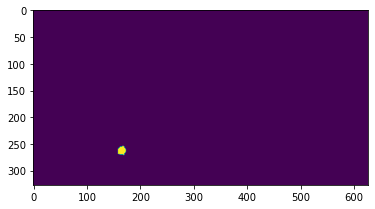

In [396]:
all_roi_ind = reduce(np.intersect1d, matching_master_roi_index_list)
plt.imshow(np.sum(master_map[all_roi_ind,:,:], axis=0))

# When checking is done, save the result.

In [397]:
#%% save the result
save_fn = f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection.npy'

result = {'master_map_list': master_map_list,
'session_map_list': session_map_list,
'viable_cell_index_list': viable_cell_index_list,
'new_master_map_list': new_master_map_list,
'new_map_list': new_map_list,
'matching_master_roi_index_list': matching_master_roi_index_list,
        }
        
np.save(save_fn, result)

print(f'JK{mouse:03} plane {pn} saved.')

JK030 plane 5 saved.


# In case there is multiple match

In [294]:
#%% Checking multiple matches

#%% When there are multi-matches for master rois
mci = 0
masterCi = multiMatchMasterInd[mci]
newCis = np.where(overlapMatrix[masterCi,:])[0]

viewer = napari.Viewer()
viewer.add_image(masterMap[masterCi,:,:], name='from Master')
errorMap = imblend_for_napari(cutMap[newCis[0],:,:].astype(int), cutMap[newCis[1],:,:].astype(int))
viewer.add_image(errorMap, rgb=True, name='new map')

print(f'Master ROI index = {masterCi}')
for nc in newCis:
    print(f'New ROI index from stat.npy = {viable_cell_index[nc]}') # to print out ROI index from stat.npy
    print(f'New ROI index from cutMap = {nc}')



Master ROI index = 99
New ROI index from stat.npy = 4
New ROI index from cutMap = 1
New ROI index from stat.npy = 46
New ROI index from cutMap = 20


divide by zero encountered in true_divide


In [293]:
np.where(np.sum(masterMap[masterCi,:,:], axis=1))[0]

array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148], dtype=int64)

In [307]:
tempMap = masterMap[masterCi,:,:]
for nci in newCis:
    tempMap += cutMap[nci,:,:]
top_boundary = np.amin(np.where(np.sum(tempMap, axis=1))[0])
bottom_boundary = np.amax(np.where(np.sum(tempMap, axis=1))[0])
left_boundary = np.amin(np.where(np.sum(tempMap, axis=0))[0])
right_boundary = np.amax(np.where(np.sum(tempMap, axis=0))[0])

spatial_correlation = np.zeros(len(newCis))
master_within_boundary = masterMap[masterCi, top_boundary:bottom_boundary, left_boundary:right_boundary]
for nci in newCis:
    new_within_boundary = cutMap[nci, top_boundary:bottom_boundary, left_boundary:right_boundary]
    

152

In [89]:
#%% When there are multi-matches for new rois
nci = 0
newCi = multiMatchNewInd[nci]
masterCis = np.where(overlapMatrix[:,newCi])[0]

viewer = napari.Viewer()
viewer.add_image(cutMap[newCi,:,:], name='New map')
errorMap = imblend_for_napari(masterMap[masterCis[0],:,:].astype(int), masterMap[masterCis[1],:,:].astype(int))
viewer.add_image(errorMap, rgb=True, name='Master map')

print(f'New ROI index from stat.npy = {tempCelli[newCi]}') 
print(f'New ROI index from cutMap = {newCi}')
for mc in masterCis:
    print(f'Master ROI index = {mc}')


New ROI index from stat.npy = 619
New ROI index from cutMap = 63
Master ROI index = 14
Master ROI index = 23


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [107]:
#%% Get the index of a specific neuron at a specific position
# from the master map
ypix = 102
xpix = 552

positionMap = np.zeros((masterMap.shape[1:]))
positionMap[ypix,xpix]=1
masterCi = np.where(np.sum(masterMap*positionMap, axis=(1,2)))[0]

napari.view_image(imblend_for_napari(masterMap[masterCi[0],:,:].astype(int), masterMap[masterCi[1],:,:].astype(int)))


divide by zero encountered in true_divide


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 163.0, 313.0), zoom=2.1822683706070287, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(0.0, 0.0, 0.0), scaled=True, size=1, style='standard'), dims=Dims(ndim=3, ndisplay=2, last_used=2, range=((0.0, 2.0, 1.0), (0.0, 326.0, 1.0), (0.0, 626.0, 1.0)), current_step=(0, 0, 0), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(enabled=False, stride=1, shape=(-1, -1)), layers=[<Image layer 'Image' at 0x15df0fca610>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position='bottom_right', font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([1., 1., 1., 1.]), font_size=10.0, position='top_left', text=''), help='', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_wheel_callbacks=[<function dims_scrol

In [88]:
#%% Find the sessions
fromSession = roiSessionInd[masterCi].astype(int)
print(sname[fromSession[0]])
print(sname[fromSession[1]])

0
2
